In [1]:
import numpy as np
import cupy as cp
import h5py
import matplotlib.pyplot as plt
import cupyx.scipy.ndimage as ndimage
from types import SimpleNamespace

# Use managed memory
import h5py
import sys
import warnings
warnings.filterwarnings("ignore", message=f".*peer.*")

sys.path.insert(0, '..')
from utils import *
from rec import Rec

# Init data sizes and parametes of the PXM of ID16A

In [2]:
step = 1

In [3]:
pfile = f'Y350c_HT_015nm'
path_out = f'/data/vnikitin/ESRF/ID16A/brain_rec/20240515/Y350c'
with h5py.File(f'{path_out}/{pfile}.h5') as fid:
    detector_pixelsize = fid['/exchange/detector_pixelsize'][0]    
    focusToDetectorDistance = fid['/exchange/focusdetectordistance'][0]    
    z1 = fid['/exchange/z1'][:]        
    theta = fid['/exchange/theta'][::step]
    shifts = fid['/exchange/shifts'][::step]
    attrs = fid['/exchange/attrs'][::step]
    pos_shifts = fid['/exchange/pos_shifts'][::step]*1e-6
    shape = fid['/exchange/data0'][::step].shape
    shape_ref = fid['/exchange/data_white_start0'].shape
    shape_dark = fid['/exchange/data_dark0'].shape
    #pos_shifts-=pos_shifts[0]


In [4]:
ndist=4
ntheta,n = shape[:2]
ndark = shape_dark[0]
nref = shape_ref[0]

In [5]:
print(ndist,ntheta,n)
print(nref,ndark)

4 3000 2048
20 20


In [6]:
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
norm_magnifications = magnifications/magnifications[0]
show = True

energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
z2 = focusToDetectorDistance-z1
magnifications = focusToDetectorDistance/z1
norm_magnifications = magnifications/magnifications[0]
distances = (z1*z2)/focusToDetectorDistance*norm_magnifications**2
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
show = True

pad = 0
npsi = int(np.ceil((2048+2*pad)/norm_magnifications[-1]/16))*16  # make multiple of 8
# npsi+=64
rotation_axis=(879-(1616-npsi//2)//2+2.5)*n/1024#n/2#(796.25+2)*n/1024#397.5*2#499.75*n//1024+npsi//2-n//2

print(rotation_axis)
npsi//=(2048//n)

1763.0


In [7]:
args = SimpleNamespace()
args.ngpus = 4

args.n = n
args.ndist = ndist
args.ntheta = ntheta
args.pad = pad
args.npsi = npsi
args.nq = n + 2 * pad
args.nchunk = 1
args.voxelsize = voxelsize
args.wavelength = wavelength
args.distance = distances
args.show = True
args.norm_magnifications = norm_magnifications

# create class
cl_rec = Rec(args)


# a = np.zeros([1,npsi,npsi],dtype='complex64')
# a[0,npsi//4:-npsi//4,npsi//4:-npsi//4]=1
# a[0,npsi//2-2:npsi//2+2,npsi//2-2:npsi//2+2]=2
# # a+=np.random.random(a.shape)-0.5
# mshow(a[0].real,True)
# b=(cl_rec.M(a,3)/norm_magnifications[3]**2)
# bb=(cl_rec.MT(b,3)/norm_magnifications[3]**2)
# print(np.sum(b*b))
# print(np.sum(bb*a))
# # print(b[0,npsi//2,npsi//2])
# mshow(a[0,npsi//2-32:npsi//2+32,npsi//2-32:npsi//2+32].real,True)#,vmin=0.97,vmax=1.03)
# mshow(b[0,n//2-32:n//2+32,n//2-32:n//2+32].real,True)#,vmin=0.97,vmax=1.03)
# mshow(bb[0,npsi//2-32:npsi//2+32,npsi//2-32:npsi//2+32].real,True)#,vmin=0.97,vmax=1.03)
# # mshow(bb[0,npsi//2-32:npsi//2+32,npsi//2-32:npsi//2+32].real,True)#,vmin=0.97,vmax=1.03)


# sss

In [8]:
data = np.empty([ntheta,ndist,n,n],dtype='float32')
with h5py.File(f'{path_out}/{pfile}_corr.h5') as fid:
    for k in range(ndist):
        data[:,k] = fid[f'/exchange/data{k}'][::step]
    ref = fid[f'/exchange/ref'][:]        

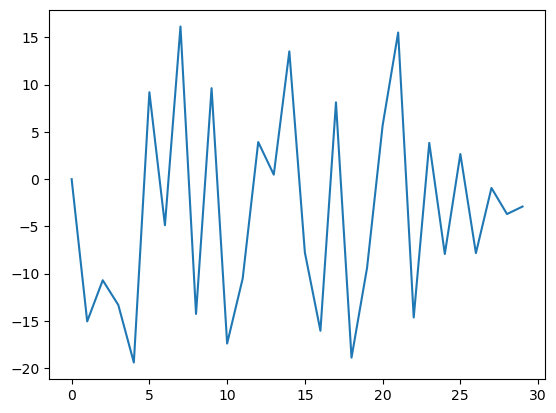

In [ ]:
shifts_random = np.zeros([ntheta,ndist,2],dtype='float32')
for k in range(ndist):
    shifts_random[:,k,0] = shifts[:,k,1]/norm_magnifications[k] 
    shifts_random[:,k,1] = shifts[:,k,0]/norm_magnifications[k] 
plt.plot(shifts_random[:,-1,1])
plt.show()

In [ ]:
rdata = data/ref

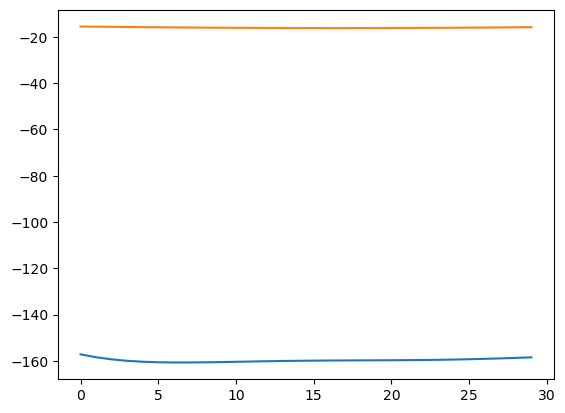

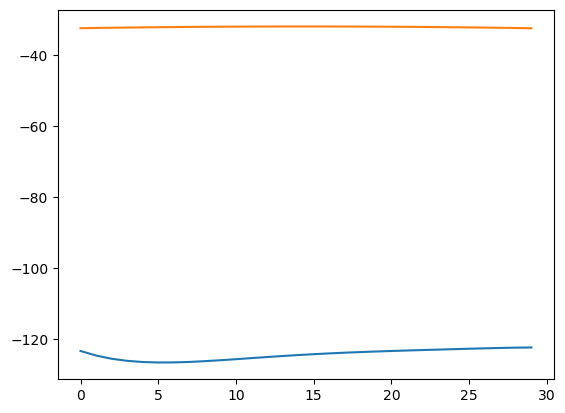

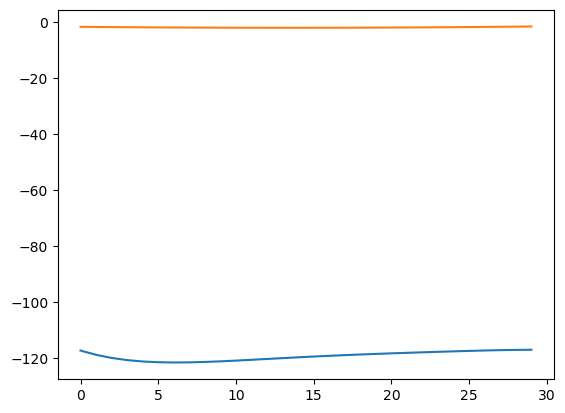

In [11]:
import scipy
pshifts = scipy.io.loadmat('/data/vnikitin/ESRF/ID16A/brain/20240515/Y350c/Y350c_HT_015nm_/rhapp_fixed.mat')['pshifts'][0,0][0]
pshifts=-pshifts.swapaxes(0,2)[:3000:step]

for k in range(1,4):
    plt.plot(pshifts[:,k,1])
    plt.plot(pshifts[:,k,0])
    plt.show()


In [12]:
shifts = pshifts+shifts_random

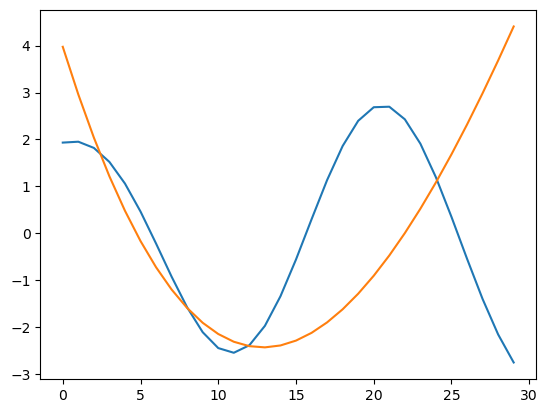

In [14]:
s = np.loadtxt('/data/vnikitin/ESRF/ID16A/brain/20240515/Y350c/Y350c_HT_015nm_/correct_correct3D.txt')[:3000:step][:,::-1]

plt.plot(s[:,1])
plt.plot(s[:,0])
plt.show()

In [15]:
s = np.tile(s[:,np.newaxis],(1,ndist,1))
# for k in range(ndist):
#     s[:,k]/=norm_magnifications[k]



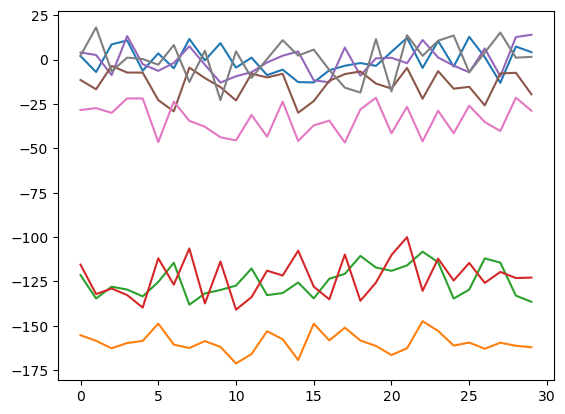

In [18]:
shifts_final = shifts+s
plt.plot(shifts_final[:,:,1])
plt.plot(shifts_final[:,:,0])
plt.show()
final = np.empty_like(rdata)

for j in np.arange(ndist):
    tmp = cl_rec.STa(shifts_final[:,j]*norm_magnifications[j],rdata[:,j].astype('complex64'),'edge')    
    tmp = (cl_rec.MT(tmp,j)/norm_magnifications[j]**2).real    
    tmp=tmp[:,npsi//2-n//2:npsi//2+n//2,npsi//2-n//2:npsi//2+n//2]
    final[:,j] = tmp   
        



In [16]:
print(f'{path_out}/{pfile}_corr.h5')
with h5py.File(f'{path_out}/{pfile}_corr.h5','a') as fid:
    
    try:
        for k in range(ndist):
            del fid[f'/exchange/check_shifts3d{k}']
        del fid[f'/exchange/cshifts_final']
    except:
        pass
    fid.create_dataset(f'/exchange/cshifts_final',data = shifts_final)
    for k in range(ndist):
        fid.create_dataset(f'/exchange/check_shifts3d{k}',data = final[:,k])    

/data/vnikitin/ESRF/ID16A/brain_rec/20240515/Y350c/Y350c_HT_015nm_corr.h5
